In [ ]:

import numpy as np
import pandas as pd
import nltk
import re

from gensim.models import Word2Vec
from nltk.tokenize import WhitespaceTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense


# melakukan import data
def import_data(dirs):
    empty = {
        "ArticleTitle": [],
        "Question": [],
        "Answer": [],
        "DifficultyFromQuestioner": [],
        "DifficultyFromAnswerer": [],
        "ArticleFile": []
    }
    df = pd.DataFrame(empty)
    for i in range(len(dirs)):
        data = pd.read_csv(dirs[i], delimiter = "\t", encoding="ISO-8859-1")
        df = df.append(data)

    df = df[["Question", "Answer"]]
    df = df.dropna()
    df = df.drop_duplicates()
    return df

# melakukan text cleaning dengan 
# mengubah text menjadi lowercase dan
# menghilangkan char yang tidak diperlukan
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)

    return text

# Perulangan untuk melakukan text cleaning
# dengan scan iterasi array sampai habis
def dataset_clean(dataset):
    ds_clean = []
    for i in range(len(dataset)):
        temp = clean_text(dataset[i])
        ds_clean.append(temp)
    return ds_clean

# Fungsi untuk membandingkan kedua list
# dengan mengubah variable list menjadi set
# dan membandingkannya
def compareList(list1, list2):
    x = set(list1)
    y = set(list2)

    if x == y:
        return 1
    else:
        return 0

# melakukan generate sekuensi data dari output - 1
# sebagai input dari decoder untuk proses training
def genx2_seq(arr, num, fill_value = 0):
    seq_shape = np.shape(arr)
    arr = arr.flatten()
    arr = np.roll(arr, num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value

    arr = arr.reshape(seq_shape)
    return arr

# fungsi untuk melakukan one hot encoding pada semua corpus dengan ukuran 
# vocabulary yang ditentukan. Hasil mempunyai tiga dimensi, dimensi pertama
# menunjukan jumlah dari kalimat yang ada, dimensi kedua adalah panjang total 
# setiap sekuen kalimat, dan dimensi ketiga adalah hasil dari one hot encoding
# dengan ukuran seluruh id dari corpus
def decoder_output_creater(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):
    decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")

    for i, seqs in enumerate(decoder_input_data):
        for j, seq in enumerate(seqs):
            if j > 0:
                decoder_output_data[i][j][seq] = 1.

    return decoder_output_data

# Melakukan preprocessing data dengan
# fungsi text cleaning, tokenizer dari library keras
# , mengubah teks menjadi sekuen dari id kata , melakukan
# padding dari sekuen menjadi jumlah elemen array tertinggi 
# pada corpus, dan melakukan one hot encoding dari hasil padding
# tadi
def preprocessing(x, y):
    x = dataset_clean(x)
    y = dataset_clean(y)

    tokenizer = Tokenizer(lower = True, split = " ")
    tokenizer.fit_on_texts(x + y)
    word2idx = tokenizer.word_index
    x_seq = tokenizer.texts_to_sequences(x)
    y_seq = tokenizer.texts_to_sequences(y)

    maxlen = max([len(i) for i in x_seq])
    maxlen2 = max([len(i) for i in y_seq])

    x_padded = pad_sequences(x_seq, padding = "post", maxlen = maxlen)
    y_padded = pad_sequences(y_seq, padding = "post", maxlen = maxlen)

    x2 = genx2_seq(y_padded, 1)

    x_encoded = decoder_output_creater(x_padded, len(x_padded), 41, 5813)
    x2_encoded = decoder_output_creater(x2, len(x2), 41, 5813)
    y_encoded = decoder_output_creater(y_padded, len(y_padded), 41, 5813)

    return x_encoded, x2_encoded, y_encoded, word2idx, tokenizer

# fungsi untuk mendeklarasikan model encoder-decoder LSTM. Dimulai dari
# input dari encoder, diteruskan menuju LSTM dengan mengembalikan nilai state,
# setelah itu menuju pada input decoder, lstm, menuju output dengan activation 
# function softmax, dan terakhir melakukan deklarasi model, model encoder, dan 
# decoder
def define_models(n_input, n_output, n_units):
	# model encoder
	encoder_inputs = Input(shape=(None, n_input))
	encoder = LSTM(n_units, return_state=True)
	encoder_outputs, state_h, state_c = encoder(encoder_inputs)
	encoder_states = [state_h, state_c]
	# model decoder
	decoder_inputs = Input(shape=(None, n_output))
	decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
	decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
	decoder_dense = Dense(n_output, activation='softmax')
	decoder_outputs = decoder_dense(decoder_outputs)
	model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
	# model inference encoder
	encoder_model = Model(encoder_inputs, encoder_states)
	# model inference decoder
	decoder_state_input_h = Input(shape=(n_units,))
	decoder_state_input_c = Input(shape=(n_units,))
	decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
	decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
	decoder_states = [state_h, state_c]
	decoder_outputs = decoder_dense(decoder_outputs)
	decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
	# return model
	return model, encoder_model, decoder_model

# fungsi untuk melakukan prediksi dari input sekuen data, prediksi dilakukan
# dengan memasukkan input kedalam model prediksi inference
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
	# encode
	state = infenc.predict(source)
	# start of sequence input
	target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
	# collect predictions
	output = list()
	for t in range(n_steps):
		# predict next char
		yhat, h, c = infdec.predict([target_seq] + state)
		# store prediction
		output.append(yhat[0,0,:])
		# update state
		state = [h, c]
		# update target sequence
		target_seq = yhat
	return array(output)

# fungsi untuk melakukan transformasi inverse dari one hot encode
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]


# variable global untuk parameter model
n_features = 5813
n_steps_in = 41
n_steps_out = 41

# deklarasi model
train, infenc, infdec = define_models(n_features, n_features, 128)
train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# lokasi direktori dataset
dirs = [
    "S08.txt"
]

# import dataset melalui library pandas
df = import_data(dirs)
x = df["Question"].values
y = df["Answer"].values

# preprocessing data
x, x2, y, word2idx, tokenizer = preprocessing(x, y)

# melakukan print dimensi array input dan output
print(np.shape(x))
print(np.shape(x2)) 
print(np.shape(y))

input("Start Training")

# mulai training dengan menyimpan parameter hasil training pada variable
# history
history = train.fit([x, x2], y, validation_split=0.2, epochs=20)

(1321, 41, 5813)
(1321, 41, 5813)
(1321, 41, 5813)
Start Training
Epoch 1/20
33/33 [==============================] - 55s 2s/step - loss: 7.4897 - accuracy: 0.7393 - val_loss: 1.3254 - val_accuracy: 0.9350
Epoch 2/20
33/33 [==============================] - 49s 1s/step - loss: 0.9594 - accuracy: 0.9247 - val_loss: 0.7370 - val_accuracy: 0.9350
Epoch 3/20
33/33 [==============================] - 52s 2s/step - loss: 0.7021 - accuracy: 0.9312 - val_loss: 0.7124 - val_accuracy: 0.9350
Epoch 4/20
33/33 [==============================] - 52s 2s/step - loss: 0.7019 - accuracy: 0.9266 - val_loss: 0.7003 - val_accuracy: 0.9350
Epoch 5/20
33/33 [==============================] - 48s 1s/step - loss: 0.6937 - accuracy: 0.9263 - val_loss: 0.6972 - val_accuracy: 0.9350
Epoch 6/20
33/33 [==============================] - 48s 1s/step - loss: 0.6488 - accuracy: 0.9302 - val_loss: 0.6941 - val_accuracy: 0.9350
Epoch 7/20
33/33 [==============================] - 53s 2s/step - loss: 0.6460 - accuracy: 0.9

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


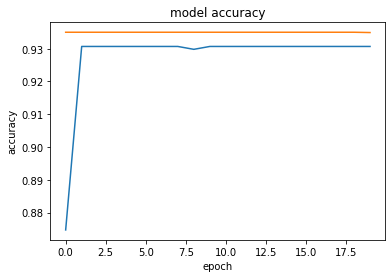

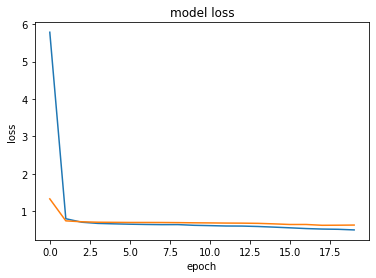

In [ ]:
# deklarasi library untuk grafik
import matplotlib.pyplot as plt
# menampilkan python key untuk hasil training tadi
print(history.history.keys())
# menampilkan grafik untuk akurasi dan validasinya
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()
# menampilkan grafik untuk loss dan validasinya
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
# deklarasi fungsi argumen maximum dari library numpy
from numpy import argmax

# preprocessing data untuk testing, proses dimulai
# dengan melakukan text cleaning, generate id untuk kata2
# , melakukan tokenizing corpus, generate sekuen data, padding, 
# dan pemrosesan one hot encoding
def test_preprocessing(tokenizer, x, y, maxlen):
  x = dataset_clean(x)
  y = dataset_clean(y)
  word2idx = tokenizer.word_index
  x_seq = tokenizer.texts_to_sequences(x)
  y_seq = tokenizer.texts_to_sequences(y)

  x_padded = pad_sequences(x_seq, padding = "post", maxlen = maxlen)
  y_padded = pad_sequences(y_seq, padding = "post", maxlen = maxlen)

  x2 = genx2_seq(y_padded, 1)

  x_encoded = decoder_output_creater(x_padded, len(x_padded), 41, 5813)
  x2_encoded = decoder_output_creater(x2, len(x2), 41, 5813)
  y_encoded = decoder_output_creater(y_padded, len(y_padded), 41, 5813)

  return x_encoded, x2_encoded, y_encoded, word2idx


# fungsi untuk memprediksi sekuen kalimat yang masuk
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
	# encode
  state = infenc.predict(source)
	# start of sequence input
  target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
  #print(target_seq)
	# collect predictions
  output = list()
  for t in range(n_steps):
    # predict next char
    yhat, h, c = infdec.predict([target_seq] + state)
    # store prediction
    output.append(yhat[0,0,:])
    # update state
    state = [h, c]
		# update target sequence
    target_seq = yhat
  return np.array(output)

# testing
# pertanyaan untuk testing
question = [
            "Are beetles insect",
            "who montevideo",
            "what turtle is extinct",
            "what ghana mean",
            "where finland located"
]

# jawaban dari pertanyaan diatas
answer = [
          "Yes",
          "The Spanish",
          "Paracryptodira",
          "warrior king",
          "northern europe"
]

# deklarasi variable untuk total data untuk test
total, correct = 5, 0

# melakukan perulangan dari data test, jika hasil prediksi dan aktual 
# sama, maka menambah rasio akurasi. Terakhir, tampilkan akurasi.
for i in range(len(questions)):
  print(i)
  arr_question = []
  arr_answer = []
  arr_question.append(questions[i])
  arr_answer.append(answers[i])
  x, x2, y, word2idx = test_preprocessing(tokenizer, arr_question, arr_answer, 41)
  print(np.shape(x))
  target = predict_sequence(infenc, infdec, x, n_steps_out, n_features)
  target = np.round(target)
  if np.array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
    correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))

0
(1, 41, 5813)
1
(1, 41, 5813)
2
(1, 41, 5813)
3
(1, 41, 5813)
4
(1, 41, 5813)
Accuracy: 40.00%
